# The Intro to Bayesian Nets example

## First step: Creating the synthetic applicant data

In [1]:
import pandas as pd
from math import erf, sqrt, log
import numpy as np
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn import metrics
from causalnex.evaluation import classification_report
import matplotlib.pyplot as plt 
from causalnex.evaluation import roc_auc
from causalnex.inference import InferenceEngine
from causalnex.discretiser import Discretiser
import seaborn as sns

In [ ]:
# Create 1000 candidates with normal distributed drive:
size = 6000
cols = ['drive']
candidate = pd.DataFrame((((np.random.normal(loc=4, size=(size,len(cols)), scale=1))/8)*100), columns=cols, index=[*range(size)])


def normal_cdf_mapper(banana,sigma=1,mu=4):
    """
    cumulative distrib fct of the normal distribution for the calculation of social_commitment/education
    """
    x = banana['drive']*8/100
    return int((1 + erf((x-mu)/(sigma*sqrt(2))))/2 *1.3)

# Introduce skewed distributions for font/social commitment:
candidate['font'] = np.random.choice(np.arange(0, 4), size=size, p=[0.50, 0.3, 0.1, 0.1])
candidate['social_commitment'] = candidate.apply(lambda x: normal_cdf_mapper(x), axis=1)/10 * np.random.choice(np.arange(0,4), size=size, p=[0.25,0.25,0.25,0.25])

# # Creating a causal dependence between drive/education and drive/work experience
# def drive_mapper(banana, interval, offset):
#     """
#     Function encoding the relation between drive/education & drive/work experience.
#     """
#     # if offset!='':
#     #     return normal_cdf(banana['drive']) + offset
#     # if offset=='':
#     #     return normal_cdf(banana['drive'])* (((np.random.normal(size=(size,len(cols)), scale=10)+6)/12)*10)
#     # if banana['drive']>=interval[2]:
#     #     return (((np.random.normal(size=1,scale=10)+6)/12)*10+50)[0]
#     # if banana['drive']>=0:
#     #     return (((np.random.normal(size=1,scale=10)+6)/12)*10+30)[0]
#     return 0 

# # Make it more likely to be hired if your colour is 1, with a likelihood of getting hired of 60% if colour==1, and 50% if colour==0:
# def hired_mapper(banana):
#     """
#     Function making it more likely to be hired if colour==1 then colour==0, at comparable skill/experience/... levels
#     """
#     # if banana['font']==1 and banana['hired']>=0.6*banana['hired'].max():
#     #     return np.random.choice(np.arange(0, 2), p=[0.2, 0.8])
#     # if banana['font']==1 and banana['hired']<0.6*banana['hired'].max():
#     #     return np.random.choice(np.arange(0, 2), p=[0.8, 0.2])
#     # if banana['font']==0 and banana['hired']>=(0.75*banana['hired'].max()):
#     #     return np.random.choice(np.arange(0, 2), p=[0.3, 0.7])
#     # if banana['font']==0 and banana['hired']<(0.75*banana['hired'].max()):
#     #     return np.random.choice(np.arange(0, 2), p=[0.95, 0.05])
#     # return 0 
#     if banana['font']>=3 and banana['hired']>=0.2*banana['hired'].max():
#         return 1
#     if banana['font']>=2 and banana['hired']>=0.5*banana['hired'].max():
#         return 0
#     if banana['font']>=1 and banana['hired']>=0.8*banana['hired'].max():
#         return 1
#     if banana['font']==0 and banana['hired']>=0.9*banana['hired'].max():
#         return 0
#     return 0

# # Completeing the dataset with the encoded data:
# candidate['education'] = candidate.apply(lambda x: drive_mapper(x, [80, 65, 50],0), axis=1)
# candidate['work_experience'] = candidate.apply(lambda x: drive_mapper(x, [50, 35, 20],0), axis=1)

# # More higher skill levels/experience/... are desirable, so to make the likelihood of getting hired depend on it:
# # candidate['hired'] = candidate.sum(axis=1)
# candidate['hired'] = 4*candidate['font']*candidate['font'] + candidate['education']*20 + 0.5*candidate['work_experience'] + 10*candidate['drive'] + 10*candidate['social_commitment']+10*candidate['drive']
# print(candidate['hired'].describe())
# candidate['hired'] = candidate.apply(lambda x: hired_mapper(x), axis=1)

# and loading the initial data:
# abc = pd.read_csv(r'observations_table.csv')

In [185]:
# Create 1000 candidates with normal distributed drive:
size = 6000
cols = ['drive']
candidate = pd.DataFrame((((np.random.normal(loc=4, size=(size,len(cols)), scale=1))/8)*100), columns=cols, index=[*range(size)])


def normal_cdf_mapper(banana,sigma=1,mu=4):
    """
    cumulative distrib fct of the normal distribution for the calculation of social_commitment/education
    """
    x = banana['drive']*8/100
    return int((1 + erf((x-mu)/(sigma*sqrt(2))))/2 *1.3)

def normal_cdf(x,sigma=1,mu=4):
    """
    cumulative distrib fct of the normal distribution for the calculation of social_commitment/education
    """
    x = x * 8/100
    return int((1 + erf((x-mu)/(sigma*sqrt(2))))/2 *100)

# Introduce skewed distributions for font:
candidate['font'] = np.random.choice(np.arange(0, 4), size=size, p=[0.50, 0.3, 0.1, 0.1])

# And for soc_comm/edu shifted log/normal distributions:
candidate['social_commitment'] = candidate['drive']/4 + np.random.lognormal(size=size, mean = 4, sigma=.2)
candidate['social_commitment'] /= candidate['social_commitment'].max()*100
candidate['education'] = candidate['drive']/4 + ((np.random.normal(loc=4, size=size, scale=1))/8)*100
candidate['education'] /= candidate['education'].max()*100

# Creating a causal dependence between drive/education and drive/work experience
def drive_mapper(banana, interval, offset):
    """
    Function encoding the relation between drive/education & drive/work experience.
    """
    if banana['drive']>=interval[0]:
        return normal_cdf(banana['drive']) + offset
    if banana['drive']>=interval[1]:
        return normal_cdf(banana['drive'])* (((np.random.normal(size=1,scale=10)+6)/12)*10)[0]
    if banana['drive']>=interval[2]:
        return (((np.random.normal(size=1,scale=10)+6)/12)*10+50)[0]
    if banana['drive']>=0:
        return (((np.random.normal(size=1,scale=10)+6)/12)*10+30)[0]
    return 0 

# Make it more likely to be hired if your colour is 1, with a likelihood of getting hired of 60% if colour==1, and 50% if colour==0:
def hired_mapper(banana):
    """
    Function making it more likely to be hired if colour==1 then colour==0, at comparable skill/experience/... levels
    """
    # if banana['font']==1 and banana['hired']>=0.6* (banana['hired'].max()):
    #     return np.random.choice(np.arange(0, 3), p=[0.1, 0.2, 0.7])
    # if banana['font']==1 and banana['hired']<0.6* (banana['hired'].max()):
    #     return np.random.choice(np.arange(0, 3), p=[0.1, 0.2, 0.7])
    # if banana['font']==0 and banana['hired']>=0.75* (banana['hired'].max()):
    #     return np.random.choice(np.arange(0, 3), p=[0.1, 0.2, 0.7])
    # if banana['font']==0 and banana['hired']<0.75* (banana['hired'].max()):
    #     return np.random.choice(np.arange(0, 3), p=[0.1, 0.2, 0.7])
    # return 0 
    if banana['font']>=3 and banana['hired']>=0.2*banana['hired'].max():
        return 1
    if banana['font']>=2 and banana['hired']>=0.5*banana['hired'].max():
        return 0
    if banana['font']>=1 and banana['hired']>=0.8*banana['hired'].max():
        return 1
    if banana['font']==0 and banana['hired']>=0.9*banana['hired'].max():
        return 0
    return 0

# # Completeing the dataset with the encoded data:
# candidate['education'] = candidate.apply(lambda x: drive_mapper(x, [80, 65, 50],0), axis=1)
candidate['work_experience'] = candidate.apply(lambda x: drive_mapper(x, [50, 35, 20],0), axis=1)

# More higher skill levels/experience/... are desirable, so to make the likelihood of getting hired depend on it:
# candidate['hired'] = candidate.sum(axis=1)
candidate['hired'] = 1*candidate['font'] + 4*candidate['education'] + 2.5*candidate['work_experience'] + 2.5*candidate['drive'] + 4*candidate['social_commitment']+ 4*candidate['drive']
# print(candidate['hired'].describe())
candidate['hired'] = candidate.apply(lambda x: hired_mapper(x), axis=1)

# and loading the initial data:
# abc = pd.read_csv(r'observations_table.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13017c050>]],
      dtype=object)

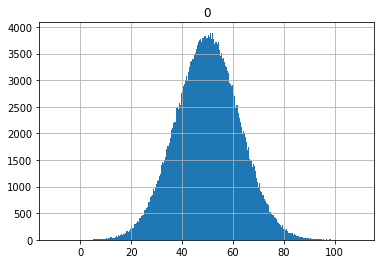

In [72]:
#pd.DataFrame((np.random.normal(loc=4,size=(1000000), scale=1))).hist(bins=100)
(pd.DataFrame(((np.random.normal(loc=4,size=(1000000), scale=1))/8))*100).hist(bins=1000)

## And the code for the initial examples:

In [ ]:
# calculate cpd p(c|h)
# coditional probability table of cooking given hungry
# reality check: each column should add up to 1
cpd2 = pd.pivot_table(abc[[hungry,cooking]],index=hungry, columns=cooking, aggfunc=np.size); 
cpd2 = (cpd2/cpd2.sum()); cpd2

In [ ]:
# cpd p(h)
cpd3 = pd.DataFrame(abc.hungry.value_counts(), columns=[hungry])
cpd3 = cpd3/cpd3.sum(); cpd3

In [ ]:
# cpd p(lt|c,h)
cpd1 = pd.pivot_table(abc,index=lunchtime, columns=[cooking,hungry], aggfunc=np.size)
cpd1 = cpd1/cpd1.sum(); cpd1

In [ ]:
# Create the structure models, which will contain the graphs:
sm = StructureModel()
sm2 = StructureModel()

In [ ]:
# example of a cyclical graph:
sm.add_edges_from([
    ('hungry', 'cooking'),
    ('cooking', 'hungry'),
    ('cooking', 'lunch time'),
    ('hungry', 'lunch time'),
    ('lunch time', 'cooking'),
    ('lunch time', 'hungry')
])

# example of a directed acyclical graph
sm2.add_edges_from([
    ('hungry', 'cooking'),
    ('cooking', 'lunch time'),
    ('hungry', 'lunch time')
])

In [ ]:
viz = plot_structure(
    sm)
filename = "./plot1.png"
viz.draw(filename)
Image(filename)

In [ ]:
viz = plot_structure(
    sm2)
filename = "./plot2.png"
viz.draw(filename)
Image(filename)

In [ ]:
# map the 'True' and 'False' observations to 1 and 0:
maps = {True: 1, False: 0}
abc2 = abc.copy()
for _ in abc2.columns:
    abc2[_] = abc2[_].map(maps)
abc2.head()

In [ ]:
# probability for p(lt|h,c)\*p(c|h)\*p(h) with h=True, c=False, lt=False
p_c_lt_h = cpd1.iloc[0,0]*cpd2.iloc[0,1]*cpd3.iloc[0,0]
print(f"Probability for p(h=True, c=False, lt=False) = {p_c_lt_h*100:.2f}%.")

# And the hiring data:

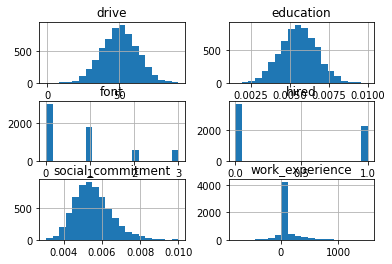

In [186]:
# check histograms for problems:
_ = candidate.hist(bins=20)

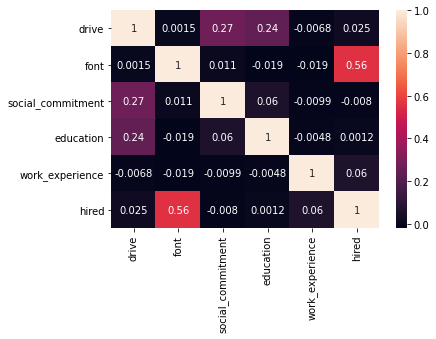

In [187]:
# some further very light EDA (exploratory data analysis):
cor = candidate.corr()

# plot the heatmap:
_ = sns.heatmap(cor,
                xticklabels=cor.columns,
                yticklabels=cor.columns,
                annot=True)

# lovely, as expected from the dataset creation, we see the right correlations

In [188]:
# Create a graph, and infer nodes and edges from pandas file:
sm5 = StructureModel()
sm5.add_edge('education','hired')
sm5.add_edge('font','hired')
sm5.add_edge('drive','education')
sm5.add_edge('drive','hired')
sm5.add_edge('drive','work_experience')
sm5.add_edge('drive','social_commitment')
sm5.add_edge('social_commitment', 'hired')
sm5.add_edge('education','work_experience')
sm5.add_edge('work_experience', 'hired')

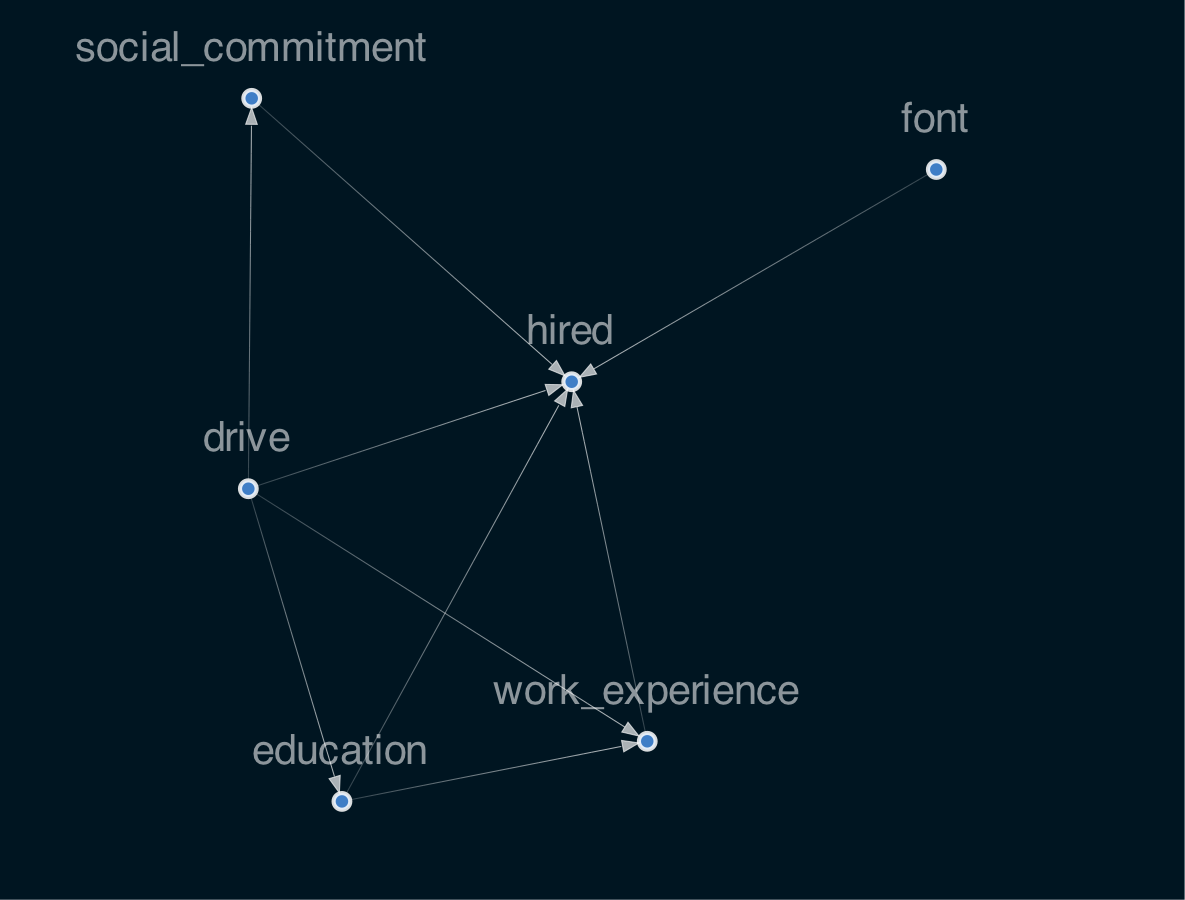

In [189]:
viz = plot_structure(
    sm5,
    graph_attributes={"scale": "1.3"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model1.png"
viz.draw(filename)
Image(filename)

In [190]:
# There is a continuous range of data for most variables. As we are not interested in the differences between e.g. education=34 and education=35, we split the variables and discretise them into fice levels: very low (0) to very high(4):

def intervals(df, col):
    """
    Create intervals for discretisation of df columns based on quartiles.
    """
    max_, min_ = df[col].max(), df[col].min()
    interval = [0.2*(max_-min_)+min_,0.4*(max_-min_)+min_,0.6*(max_-min_)+min_,0.8*(max_-min_)+min_]
    a = Discretiser(method="fixed", numeric_split_points=interval).transform(df[col].values)
    return a

candidate["education"] = intervals(candidate, 'education')
candidate["work_experience"] = intervals(candidate, 'work_experience')
candidate["drive"] = intervals(candidate, 'drive')
candidate["social_commitment"] = intervals(candidate, 'social_commitment')

# if there is a limited amount of data, a discretisation like the above will dramatically decrease performance by masking the data  

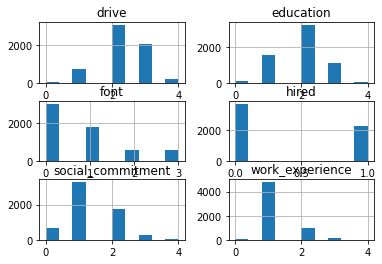

In [191]:
# check the discretisation - are all levels well populated:
a = candidate.hist()

In [173]:
## map integers back to legible labels:

# label_map = {0: "v low", 1: "low", 2: "high", 3: "v high"}
# cols = ['volatile_acidity','citric_acid','density','fixed_acidity','total_sulfur_dioxide','free_sulfur_dioxide','residual_sugar','chlorides','pH','sulphates','alcohol']

# for _ in cols:
#     wine[_] = wine[_].map(label_map)

In [192]:
# train/test split the data:
train_w, test_w = train_test_split(candidate, train_size=0.95, test_size=0.05, random_state=42)

bn = BayesianNetwork(sm5)

# Ensure that all data is seen, as some of the data may only be in the test set:
bn = bn.fit_node_states(candidate)

In [193]:
# obtain conditional probabilities from the train data:
bn = bn.fit_cpds(train_w)

In [194]:
# # conditional probabilities for quality:
# bn.cpds['hired']

In [199]:
# Let's check our bayesian nets prediction for the test_candidate:
test_candidate = test_w.index[1:2][0]
prediction = bn.predict_probability(test_w.iloc[1:2,:],'hired')
pred = (prediction.loc[test_candidate,prediction.idxmax(axis=1)].index[0]).lstrip('hired'+"_")
truth = test_w.loc[test_candidate,'hired']
print(f'The prediction is "{"hired" if float(pred)>=0.5 else "not hired"}", the true quality value is "{"not hired" if truth==0 else "not hired"}".','\n\n')
print("And a predictions outputs probabilities looking like this:")
prediction

The prediction is "not hired", the true quality value is "not hired". 


And a predictions outputs probabilities looking like this:


,hired_0,hired_1
3917,1.0,0.0


In [196]:
# To do some quality measurements, lets calculate reciever operator curve (ROC) and area under curve (AUC):

# prepare the truth: 
truth = pd.get_dummies(test_w['hired'])
for var in bn.node_states['hired']:
        if var not in truth.columns:
            truth[var] = 0

predictions = bn.predict_probability(test_w,'hired')
predictions.columns = predictions.columns.str.replace('hired_','')
fpr, tpr, _= metrics.roc_curve(truth.values.ravel(), predictions.values.ravel()) 
roc = list(zip(fpr, tpr))
a = pd.DataFrame(roc, columns=['FPR','TPR'])
a['auc'] = a['TPR']*(1-a['FPR'])
max_ =  a['auc'].idxmax()

print(f'Area under the curve (AUC): {a.loc[max_,"auc"]*100:.1f}%')
# The area under curve (AUC) is a good measure of model quality, in the case of a balanced dataset. A perfect model would have a AUC=1, a model deciding randomly AUC=1/2, and if AUC<1/2 you probably have a sign error somewhere, or the model is really, terribly bad.

# classification_report(bn, test_w, "hired")

Area under the curve (AUC): 97.3%


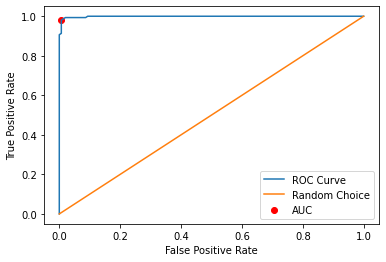

In [197]:
# plot the reciever operator curve (ROC), from which the AUC is determined. The AUC corresponds to the FPR*TPR maximum on the ROC curve inflection point.
_ = plt.plot(a['FPR'],a['TPR'], label='ROC Curve')
_ = plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],label='Random Choice')
_ = plt.scatter(a.loc[max_,'FPR'], a.loc[max_,'TPR'], c='r', label='AUC')
_ = plt.legend(loc='lower right')
# _ = plt.grid()
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')

This graph shows the quality of the model, where in an ideal case the bleu line would always very close the ideal curve fulfilling TPR*FPR=1.
The >86% area under the curve (AUC) is a good result, which with some work can surely be improved upon, especially considering the low values for [TPR](https://en.wikipedia.org/wiki/True_Positive_Rate).<br>
(Caveat: the ROC-AUC has to be taken cum granulo salis, as there is an imbalance between hired/not hired, which also manifests in the FPR/TPR skew.)

## Study of Counterfactuals and Interventions:

In [180]:
# re-fit to include all data in dataset for node modification calcs:

bn = bn.fit_cpds(candidate, method="BayesianEstimator", bayes_prior="K2")
ie = InferenceEngine(bn)

# marginals = ie.query()
# marginals["quality"]
# marginals_df = pd.DataFrame(columns=['probability'])
# for _ in marginals["quality"].keys():
#     marginals_df.loc[_,'probability'] = marginals["quality"][_]

In [181]:
def effect_of_changes(change_node, result_node, new_distrib, ie_):
    """
    Visualise the effects of changes in one node

    Input:
        change_node: (str) node the change is applied to
        result_node: (str) node we are interested in
        new_distrib: (dict) new distribution of values with keys according
                            to result node
        ie_: (causal nex inference engine object) 

    Returns:
        plot: Bar plot of the resulting changes
    """
    marg_list = [ie_.query({change_node: _})['hired'] for _ in ie._cpds[change_node]]
    before = ie_.query()[result_node]
    ie_.do_intervention(change_node,new_distrib)
    after = ie.query()[result_node]
    ie_.reset_do(change_node)
    changes = pd.DataFrame([before,after],
                           index=[f'old {change_node}',
                           f'new {change_node}'])
    changes.loc['dif'] = (changes.loc[f'new {change_node}'] - 
                          changes.loc[f'old {change_node}']
                          )*100/changes.loc[f'old {change_node}']

    a = changes.transpose()['dif'].plot.bar(rot=90)
    plt.ylabel('Change (%)')
    plt.xlabel('')
    plt.xticks([0,1], ['not hired', 'hired'], rotation='horizontal')
    return a

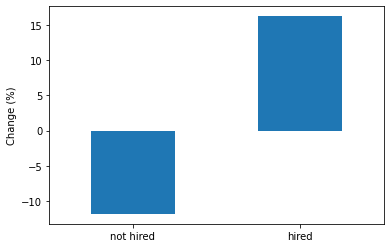

In [182]:
_ = effect_of_changes('drive', 'hired', {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0}, ie)

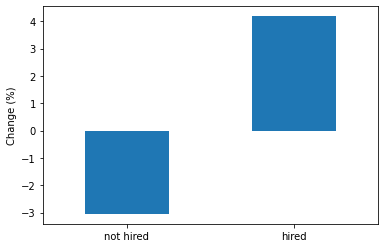

In [183]:
# shift of citric_acid to higher levels in the wine:
_ = effect_of_changes('education', 'hired', {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0}, ie)

It looks like an intervention to increase education is a v good idea, if candidate want to be hired, same for drive. The effect_of_change function allows for quick querying to determine the change that results from a shift in the underlying distributions.<br>
<br>
<br>
Moreover, in addition to interventions like the above one, bayesian nets of course also allow for a single case counterfactual analysis. As an example, looking at candidate colour:

In [184]:
cf = test_w[test_w['font']==0].iloc[0:1,:]
cf2 = cf.copy()
cf3 = cf.copy()

cf2['font'] = 1
cf3['font'] = 3

predictions_cf = bn.predict_probability(cf,'hired')
predictions_cf2 = bn.predict_probability(cf2,'hired')
predictions_cf3 = bn.predict_probability(cf3,'hired')

print(f'Changing the application font from Comic Sans (font=0) to a more appropriate font (font>=1), improves the chance of being hired for candidate {cf2.index[0]} from {predictions_cf.iloc[0,1]*100:.1f}% to about {predictions_cf2.iloc[0,1]*100:.1f}%')

Changing the application font from Comic Sans (font=0) to a more appropriate font (font>=1), improves the chance of being hired for candidate 221 from 0.9% to about 90.4%
